In [3]:
import whisper
import seaborn as sns
import matplotlib.pyplot as plt
# from pydub import AudioSegment
import os
import librosa
from IPython.display import Audio
import soundfile as sf
import pandas as pd
import re

from finalproject_util import *
import warnings
warnings.filterwarnings("ignore")

## Initial Testing

In [42]:
model = whisper.load_model("base")

In [15]:
sr = 44100
park1, _ = librosa.load("source_files/noise_files/meeting.wav", sr=sr)
speech, _ = librosa.load("source_files/speech_files/speaker_1/61-70968-0000.wav", sr=sr)


In [16]:
Audio(speech, rate=sr)

In [17]:
park_speech = add_noise(speech, park1, snr=10, randomseed=5, filepath="source_files/meeting_speech.wav")
Audio(park_speech, rate=sr)

In [10]:
sf.write('source_files/speech_files/speech_with_noise/speaker_1/meeting.wav+20snr+61-70968-0000.wav', park_speech, samplerate=sr)

NameError: name 'park_speech' is not defined

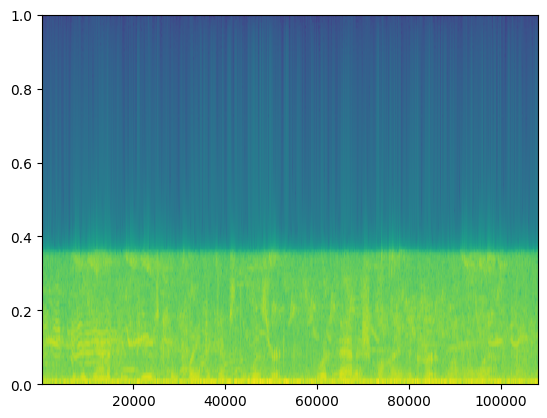

In [ ]:
plt.specgram(park_speech);

In [5]:
audio = whisper.load_audio("source_files/meeting_speech.wav")
audio = whisper.pad_or_trim(audio)
mel = whisper.log_mel_spectrogram(audio).to(model.device)
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)
print(result.text)

I had a phone call to complete against the wizard. The array is playing.


In [7]:
ref = "HE BEGAN A CONFUSED COMPLAINT AGAINST THE WIZARD WHO HAD VANISHED BEHIND THE CURTAIN ON THE LEFT"
hyp = result.text
wer(ref, hyp)

0.8235294117647058

In [ ]:
os.listdir("source_files/speech_files/speaker_1")

['61-70968-0001.flac',
 '61-70968-0000.flac',
 '61-70968.trans.txt',
 '61-70968-0003.flac',
 '61-70968-0002.flac',
 '61-70968-0004.flac']

In [ ]:
bitrates = [256, 128, 64, 32, 16, 8]
files = ["source_files/speech_files/speaker_1/" + file 
         for file in os.listdir("source_files/speech_files/speaker_1")]
compress_decompress(files, "libmp3lame", ('wav', 'mp3'), bitrates=bitrates)

## Experimentation

### Outline:
- Add all noises to all audio files at all signal-to-noise ratios
    - store these files into speaker-specific directories under `source_files/speech_with_noise`
    - noises: **[none, park, overlapping speech]**
    - signal-noise-ratios: **[10, 20]**
- Use `compress_decompress` to first compress each file into each format, then decompress to wav, storing in format-specific directories under `audio`
    - compression methods: **[mp3, opus, opus speech, downsampling]**
    - bitrates: **[128, 64, 32, 16, 8]**
- Run all files through Whisper, then measure Word Error Rate of output
    - Average WER for all files from same speaker
    - Present as heatmaps: x-axis is bitrate, y-axis is snr, color is WER
        - ideal: WER high everywhere
        - expected: WER higher around edges, low near origin

### Adding noise to audio files

In [6]:
noise_file_names = ['meeting.wav', 'park.wav']
sr = 44100
speakers = ['speaker_1', 'speaker_2']
snrs = [10, 20]

# loop through noise sources
for noise_file in noise_file_names:
    noise_codec = 'source_files/noise_files/' + noise_file
    noise, _ = librosa.load(noise_codec, sr=sr)
    
    # loop through speaker folders
    for speaker in speakers:
        signal_file_names = os.listdir(f'source_files/speech_files/{speaker}')
        
        # loop through signal files
        for signal_file in signal_file_names:
            try:
                signal_codec = f'source_files/speech_files/{speaker}/{signal_file}'
                signal, _ = librosa.load(signal_full, sr=sr)
                
                # add noise with all snrs
                for snr in snrs:
                    save_path = f'source_files/speech_with_noise/{speaker}+{noise_file}+{snr}snr+{signal_file}'
                    add_noise(signal, noise, 
                            snr=snr, randomseed=5,
                            filepath=save_path)
            # ignore the .txt files
            except BaseException as e:
                print("Error in file:", signal_file)
                print(e)
                
                

Error in file: 61-70968.trans.txt

Error in file: 121-121726.trans.txt

Error in file: 61-70968.trans.txt

Error in file: 121-121726.trans.txt



### Compressing then decompressing each file

In [7]:
filepaths = [f'source_files/speech_with_noise/{filename}' 
             for filename in os.listdir('source_files/speech_with_noise/')]
bitrates = [128, 64, 32, 16, 8]
len(filepaths)

10

In [11]:
compress_decompress(filepaths, 'libmp3lame', ('wav', 'mp3'), bitrates=bitrates);

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

File audio/mp3/speaker_1+meeting.wav+20snr+61-70968-0000+128kbps.mp3 already exists
File audio/mp3/speaker_1+meeting.wav+20snr+61-70968-0000+64kbps.mp3 already exists
File audio/mp3/speaker_1+meeting.wav+20snr+61-70968-0000+32kbps.mp3 already exists
File audio/mp3/speaker_1+meeting.wav+20snr+61-70968-0000+16kbps.mp3 already exists
File audio/mp3/speaker_1+meeting.wav+20snr+61-70968-0000+8kbps.mp3 already exists


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

File audio/mp3/speaker_1+silence.wav+10snr+61-70968-0000+128kbps.mp3 already exists
File audio/mp3/speaker_1+silence.wav+10snr+61-70968-0000+64kbps.mp3 already exists
File audio/mp3/speaker_1+silence.wav+10snr+61-70968-0000+32kbps.mp3 already exists
File audio/mp3/speaker_1+silence.wav+10snr+61-70968-0000+16kbps.mp3 already exists
File audio/mp3/speaker_1+silence.wav+10snr+61-70968-0000+8kbps.mp3 already exists
File audio/mp3/speaker_2+silence.wav+10snr+121-121726-0000+128kbps.mp3 already exists
File audio/mp3/speaker_2+silence.wav+10snr+121-121726-0000+64kbps.mp3 already exists
File audio/mp3/speaker_2+silence.wav+10snr+121-121726-0000+32kbps.mp3 already exists
File audio/mp3/speaker_2+silence.wav+10snr+121-121726-0000+16kbps.mp3 already exists
File audio/mp3/speaker_2+silence.wav+10snr+121-121726-0000+8kbps.mp3 already exists


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

File audio/mp3/speaker_2+meeting.wav+10snr+121-121726-0000+128kbps.mp3 already exists
File audio/mp3/speaker_2+meeting.wav+10snr+121-121726-0000+64kbps.mp3 already exists
File audio/mp3/speaker_2+meeting.wav+10snr+121-121726-0000+32kbps.mp3 already exists
File audio/mp3/speaker_2+meeting.wav+10snr+121-121726-0000+16kbps.mp3 already exists
File audio/mp3/speaker_2+meeting.wav+10snr+121-121726-0000+8kbps.mp3 already exists
File audio/mp3/speaker_2+meeting.wav+20snr+121-121726-0000+128kbps.mp3 already exists
File audio/mp3/speaker_2+meeting.wav+20snr+121-121726-0000+64kbps.mp3 already exists
File audio/mp3/speaker_2+meeting.wav+20snr+121-121726-0000+32kbps.mp3 already exists
File audio/mp3/speaker_2+meeting.wav+20snr+121-121726-0000+16kbps.mp3 already exists
File audio/mp3/speaker_2+meeting.wav+20snr+121-121726-0000+8kbps.mp3 already exists
File audio/mp3/speaker_1+meeting.wav+10snr+61-70968-0000+128kbps.mp3 already exists
File audio/mp3/speaker_1+meeting.wav+10snr+61-70968-0000+64kbps.mp

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

In [12]:
compress_decompress(filepaths, 'libopus', ('wav', 'opus'), bitrates=bitrates)

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

File audio/opus/speaker_1+meeting.wav+20snr+61-70968-0000+128kbps.opus already exists
File audio/opus/speaker_1+meeting.wav+20snr+61-70968-0000+64kbps.opus already exists
File audio/opus/speaker_1+meeting.wav+20snr+61-70968-0000+32kbps.opus already exists
File audio/opus/speaker_1+meeting.wav+20snr+61-70968-0000+16kbps.opus already exists
File audio/opus/speaker_1+meeting.wav+20snr+61-70968-0000+8kbps.opus already exists


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

File audio/opus/speaker_1+silence.wav+10snr+61-70968-0000+128kbps.opus already exists
File audio/opus/speaker_1+silence.wav+10snr+61-70968-0000+64kbps.opus already exists
File audio/opus/speaker_1+silence.wav+10snr+61-70968-0000+32kbps.opus already exists
File audio/opus/speaker_1+silence.wav+10snr+61-70968-0000+16kbps.opus already exists
File audio/opus/speaker_1+silence.wav+10snr+61-70968-0000+8kbps.opus already exists
File audio/opus/speaker_2+silence.wav+10snr+121-121726-0000+128kbps.opus already exists
File audio/opus/speaker_2+silence.wav+10snr+121-121726-0000+64kbps.opus already exists
File audio/opus/speaker_2+silence.wav+10snr+121-121726-0000+32kbps.opus already exists
File audio/opus/speaker_2+silence.wav+10snr+121-121726-0000+16kbps.opus already exists
File audio/opus/speaker_2+silence.wav+10snr+121-121726-0000+8kbps.opus already exists


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

File audio/opus/speaker_2+meeting.wav+10snr+121-121726-0000+128kbps.opus already exists
File audio/opus/speaker_2+meeting.wav+10snr+121-121726-0000+64kbps.opus already exists
File audio/opus/speaker_2+meeting.wav+10snr+121-121726-0000+32kbps.opus already exists
File audio/opus/speaker_2+meeting.wav+10snr+121-121726-0000+16kbps.opus already exists
File audio/opus/speaker_2+meeting.wav+10snr+121-121726-0000+8kbps.opus already exists
File audio/opus/speaker_2+meeting.wav+20snr+121-121726-0000+128kbps.opus already exists
File audio/opus/speaker_2+meeting.wav+20snr+121-121726-0000+64kbps.opus already exists
File audio/opus/speaker_2+meeting.wav+20snr+121-121726-0000+32kbps.opus already exists
File audio/opus/speaker_2+meeting.wav+20snr+121-121726-0000+16kbps.opus already exists
File audio/opus/speaker_2+meeting.wav+20snr+121-121726-0000+8kbps.opus already exists
File audio/opus/speaker_1+meeting.wav+10snr+61-70968-0000+128kbps.opus already exists
File audio/opus/speaker_1+meeting.wav+10snr+

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

In [13]:
compress_decompress(filepaths, 'libopus -application voip', ('wav', 'opus'), bitrates=bitrates, folder_override="_speech")

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

File audio/opus_speech/speaker_1+meeting.wav+20snr+61-70968-0000+128kbps.opus already exists
File audio/opus_speech/speaker_1+meeting.wav+20snr+61-70968-0000+64kbps.opus already exists
File audio/opus_speech/speaker_1+meeting.wav+20snr+61-70968-0000+32kbps.opus already exists
File audio/opus_speech/speaker_1+meeting.wav+20snr+61-70968-0000+16kbps.opus already exists
File audio/opus_speech/speaker_1+meeting.wav+20snr+61-70968-0000+8kbps.opus already exists


[out#0/opus @ 0x128e1cfd0] video:0kB audio:140kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.869401%
size=     141kB time=00:00:08.45 bitrate= 136.4kbits/s speed= 166x    
ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid 

File audio/opus_speech/speaker_1+silence.wav+10snr+61-70968-0000+128kbps.opus already exists
File audio/opus_speech/speaker_1+silence.wav+10snr+61-70968-0000+64kbps.opus already exists
File audio/opus_speech/speaker_1+silence.wav+10snr+61-70968-0000+32kbps.opus already exists
File audio/opus_speech/speaker_1+silence.wav+10snr+61-70968-0000+16kbps.opus already exists
File audio/opus_speech/speaker_1+silence.wav+10snr+61-70968-0000+8kbps.opus already exists
File audio/opus_speech/speaker_2+silence.wav+10snr+121-121726-0000+128kbps.opus already exists
File audio/opus_speech/speaker_2+silence.wav+10snr+121-121726-0000+64kbps.opus already exists
File audio/opus_speech/speaker_2+silence.wav+10snr+121-121726-0000+32kbps.opus already exists
File audio/opus_speech/speaker_2+silence.wav+10snr+121-121726-0000+16kbps.opus already exists
File audio/opus_speech/speaker_2+silence.wav+10snr+121-121726-0000+8kbps.opus already exists


[out#0/opus @ 0x129e06700] video:0kB audio:83kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.915199%
size=      83kB time=00:00:04.89 bitrate= 139.7kbits/s speed= 118x    
ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid -

File audio/opus_speech/speaker_2+meeting.wav+10snr+121-121726-0000+128kbps.opus already exists
File audio/opus_speech/speaker_2+meeting.wav+10snr+121-121726-0000+64kbps.opus already exists
File audio/opus_speech/speaker_2+meeting.wav+10snr+121-121726-0000+32kbps.opus already exists
File audio/opus_speech/speaker_2+meeting.wav+10snr+121-121726-0000+16kbps.opus already exists
File audio/opus_speech/speaker_2+meeting.wav+10snr+121-121726-0000+8kbps.opus already exists
File audio/opus_speech/speaker_2+meeting.wav+20snr+121-121726-0000+128kbps.opus already exists
File audio/opus_speech/speaker_2+meeting.wav+20snr+121-121726-0000+64kbps.opus already exists
File audio/opus_speech/speaker_2+meeting.wav+20snr+121-121726-0000+32kbps.opus already exists
File audio/opus_speech/speaker_2+meeting.wav+20snr+121-121726-0000+16kbps.opus already exists
File audio/opus_speech/speaker_2+meeting.wav+20snr+121-121726-0000+8kbps.opus already exists
File audio/opus_speech/speaker_1+meeting.wav+10snr+61-70968-

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-li

In [15]:
fp = 'audio/test_folder/speaker_2+silence.wav+10snr+121-121726-0000+128kbps.wav'
re.findall(r'/([^/]+)\.', fp)

['speaker_2+silence.wav+10snr+121-121726-0000+128kbps']

In [25]:
# Separate script for downsampling
# WAVs are stored in 16-bit bit depth, so their bit rate is sample-rate * 16 bps, 
# or sr * 16 / 1000 kbps
sample_rates = [br * 1000 // 16 for br in bitrates]
for fp in filepaths:
    file_name = re.findall(r'/([^/]+)\.', fp)[0]
    signal, _ = librosa.load(fp, sr=44100)
    for i in range(len(sample_rates)):
        sr = sample_rates[i]
        bitrate = bitrates[i]
        downsampled = librosa.resample(signal, orig_sr=44100, target_sr=sr)
        out_path = f"audio/downsampling/{file_name}+{bitrate}kpbs.wav"
        sf.write(out_path, downsampled, samplerate=sr)

### Running through Whisper

In [27]:
def evaluate_wer(filepath, model, codec):
    
    # generate text output
    audio = whisper.load_audio(filepath)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(model.device)
    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    
    # get file info
    filename = filepath.split("/")[-1]
    file_info = filename.split("+")
    speaker, noise, snr, signal, kbps = file_info
    kbps, filetype = kbps.split(".")
    
    # evaluate result
    hyp = result.text
    file_code = re.findall(r'\d+-\d+', signal)[0]
    ref_doc_path = f"source_files/ground_truths/{file_code}.trans.txt"
    with open(ref_doc_path) as ref_doc:
        lines = ref_doc.readlines()
        for line in lines:
                line = line.split(' ')
                sig_code = line[0]
                text = ' '.join(line[1:])
                if sig_code == signal:
                        ref = text
                        break
    error = wer(ref, hyp)
    results = {
        "file": [signal],
        "speaker": [speaker],
        "noise": [noise],
        "codec": [codec],
        "snr": [int(snr[:-3])],
        "kbps": [int(kbps[:-4])],
        "wer": [error]
    }
    return pd.DataFrame(results)
# evaluate_wer('audio/test_folder/speaker_1+meeting.wav+10snr+61-70968-0000+8kbps.wav', model)

In [28]:
model = whisper.load_model('base')
codecs = ['downsampling', 'opus', 'mp3', 'opus_speech']
results = []
for codec in codecs:
    folder_path = f'audio/{codec}'
   u file_paths = [f'audio/{codec}/{file}' for file in os.listdir(folder_path)]
    for file_path in file_paths:
        try:
            if file_path.split(".")[-1] == "wav":
                results.append(evaluate_wer(file_path, model, codec))
        except BaseException as e:
            print("Error in file:", file_path)
            print(e)
full_results = pd.concat(results)

In [35]:
full_results

,Unnamed: 0,file,speaker,noise,codec,snr,kbps,wer
0,0,121-121726-0000,speaker_2,meeting.wav,downsampling,10,64,9.823529
1,0,121-121726-0000,speaker_2,meeting.wav,downsampling,10,16,1.000000
2,0,121-121726-0000,speaker_2,silence.wav,downsampling,10,128,0.176471
3,0,61-70968-0000,speaker_1,park.wav,downsampling,20,64,0.117647
4,0,61-70968-0000,speaker_1,park.wav,downsampling,20,16,0.941176
...,...,...,...,...,...,...,...,...
145,0,121-121726-0000,speaker_2,meeting.wav,opus_speech,10,64,1.000000
146,0,121-121726-0000,speaker_2,meeting.wav,opus_speech,10,16,0.941176
147,0,61-70968-0000,speaker_1,park.wav,opus_speech,20,64,0.117647
148,0,121-121726-0000,speaker_2,silence.wav,opus_speech,10,128,0.176471


In [34]:
full_results.to_csv("source_files/results.csv", index=False)

### Analysis and Results

In [57]:
full_results = pd.read_csv("source_files/results(1).csv").iloc[:, 2:]

In [58]:
full_results

,file,speaker,noise,codec,snr,kbps,wer
0,121-121726-0000,speaker_2,meeting.wav,downsampling,10,64,9.823529
1,121-121726-0000,speaker_2,meeting.wav,downsampling,10,16,1.000000
2,121-121726-0000,speaker_2,silence.wav,downsampling,10,128,0.176471
3,61-70968-0000,speaker_1,park.wav,downsampling,20,64,0.117647
4,61-70968-0000,speaker_1,park.wav,downsampling,20,16,0.941176
...,...,...,...,...,...,...,...
195,121-121726-0000,speaker_2,meeting.wav,opus_speech,10,64,1.000000
196,121-121726-0000,speaker_2,meeting.wav,opus_speech,10,16,0.941176
197,61-70968-0000,speaker_1,park.wav,opus_speech,20,64,0.117647
198,121-121726-0000,speaker_2,silence.wav,opus_speech,10,128,0.176471


In [103]:
codec_results = full_results[full_results['codec'] != 'downsampling']
codec_palette = {"downsampling": "lightgrey",
                 "mp3": "cornflowerblue",
                 "opus": "orange",
                 "opus_speech": "green"}

Text(0, 0.5, 'Word Error Rate')

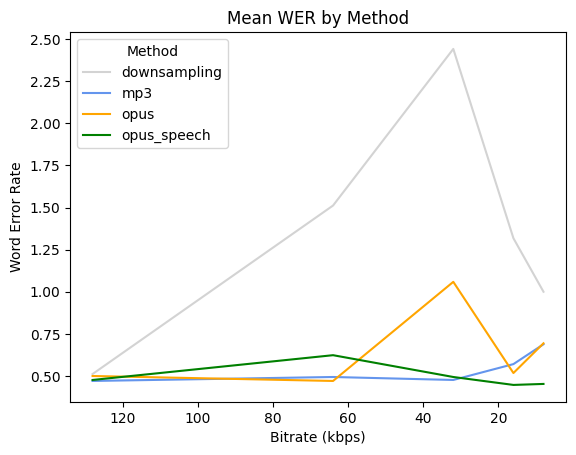

In [108]:
fig, axs = plt.subplots(1, 1)
results_by_codec = full_results.groupby(["codec", "kbps"])['wer'].mean().reset_index()
fig = sns.lineplot(data=results_by_codec, x='kbps', y='wer', hue='codec',
                   palette=codec_palette)
axs.invert_xaxis()
plt.title("Mean WER by Method")
plt.legend(title='Method')
fig.set_xlabel("Bitrate (kbps)")
fig.set_ylabel("Word Error Rate")

In [109]:
results_by_codec

,codec,kbps,wer
0,downsampling,8,1.000000
1,downsampling,16,1.317647
2,downsampling,32,2.441176
3,downsampling,64,1.511765
4,downsampling,128,0.511765
5,mp3,8,0.688235
6,mp3,16,0.570588
7,mp3,32,0.476471
8,mp3,64,0.494118
9,mp3,128,0.470588


Text(0, 0.5, 'Word Error Rate')

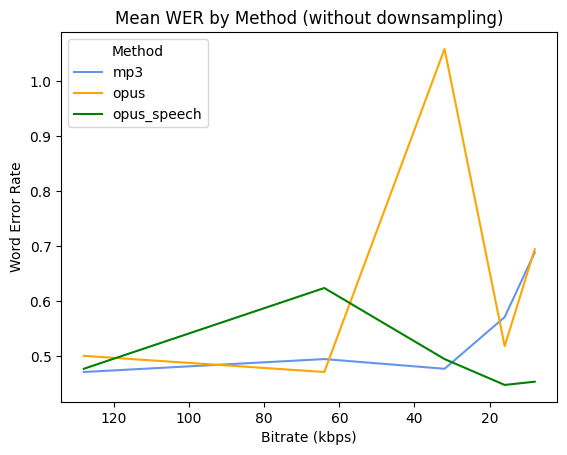

In [107]:
fig, axs = plt.subplots(1, 1)
results_by_codec = codec_results.groupby(["codec", "kbps"])['wer'].mean().reset_index()
fig = sns.lineplot(data=results_by_codec, x='kbps', y='wer', hue='codec',
                   palette=codec_palette)
axs.invert_xaxis()
plt.title("Mean WER by Method (without downsampling)")
plt.legend(title='Method')
fig.set_xlabel("Bitrate (kbps)")
fig.set_ylabel("Word Error Rate")

In [61]:
results_mp3 = full_results[full_results['codec'] == 'mp3']
results_opus = full_results[full_results['codec'] == 'opus']
results_opsp = full_results[full_results['codec'] == 'opus_speech']
results_dwns = full_results[full_results['codec'] == 'downsampling']

<Axes: xlabel='snr', ylabel='kbps'>

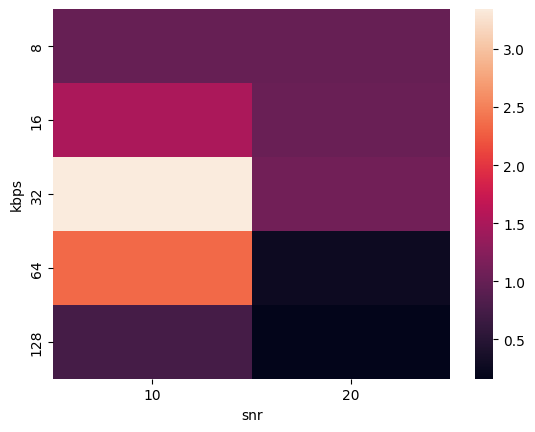

In [62]:
sns.heatmap(results_dwns.pivot_table(
    index='kbps',
    columns='snr',
    values='wer'
),
cmap=sns.color_palette("rocket", as_cmap=True))

#### Comparing compression methods

In [67]:
results_mp3.groupby(['noise', 'kbps'])['wer'].mean().reset_index()

,noise,kbps,wer
0,meeting.wav,8,0.573529
1,meeting.wav,16,0.676471
2,meeting.wav,32,0.514706
3,meeting.wav,64,0.514706
4,meeting.wav,128,0.514706
5,park.wav,8,1.044118
6,park.wav,16,0.632353
7,park.wav,32,0.647059
8,park.wav,64,0.676471
9,park.wav,128,0.617647


<Axes: xlabel='kbps', ylabel='wer'>

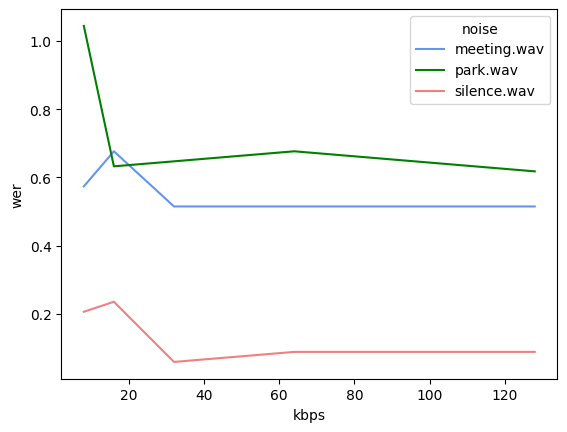

In [68]:
sns.lineplot(data=results_mp3.groupby(['noise', 'kbps'])['wer'].mean().reset_index(),
             x='kbps', y='wer', hue='noise',
             palette={'meeting.wav':'cornflowerblue', 
                      'park.wav':'green',
                      'silence.wav': 'lightcoral'})

#### Comparing Noise Types

In [75]:
silence_results = codec_results[codec_results['noise'] == 'silence.wav']
park_results = codec_results[codec_results['noise'] == 'park.wav']
meeting_results = codec_results[codec_results['noise'] == 'meeting.wav']

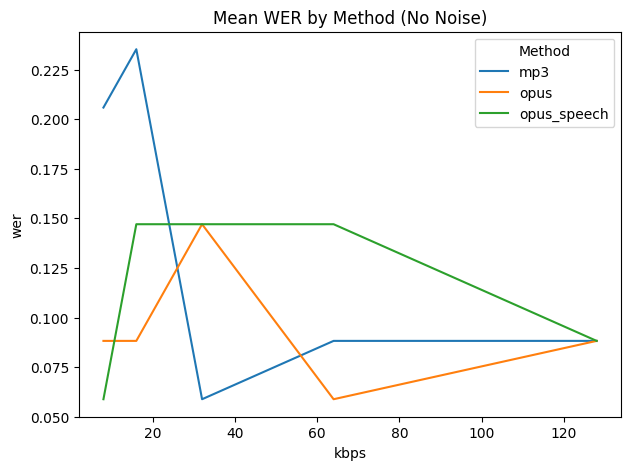

In [124]:
plt.figure(figsize=(7, 5))
sns.lineplot(data=silence_results.groupby(["codec", "kbps"])['wer'].mean().reset_index(), 
             x='kbps', y='wer', hue='codec')
axs.invert_xaxis()
plt.title("Mean WER by Method (No Noise)")
plt.legend(title='Method')
fig.set_xlabel("Bitrate (kbps)")
fig.set_ylabel("Word Error Rate");

Text(24.000000000000007, 0.5, 'Word Error Rate')

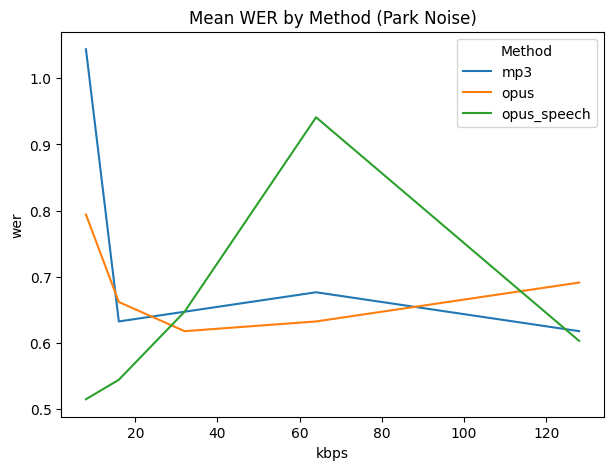

In [123]:
plt.figure(figsize=(7, 5))
sns.lineplot(data=park_results.groupby(["codec", "kbps"])['wer'].mean().reset_index(), 
             x='kbps', y='wer', hue='codec')
axs.invert_xaxis()
plt.title("Mean WER by Method (Park Noise)")
plt.legend(title='Method')
fig.set_xlabel("Bitrate (kbps)")
fig.set_ylabel("Word Error Rate")

Text(0, 0.5, 'Word Error Rate')

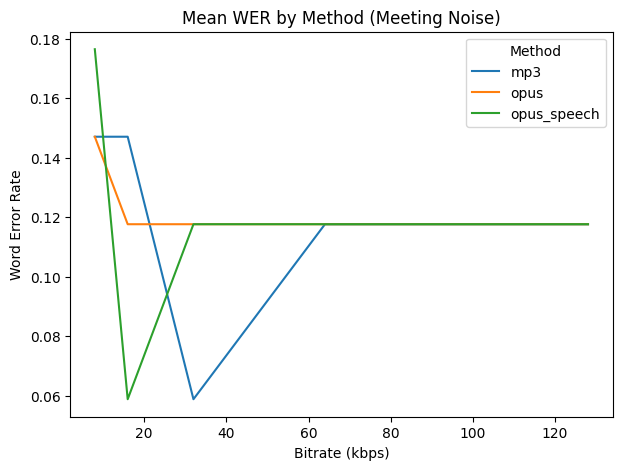

In [146]:
plt.figure(figsize=(7, 5))
fig = sns.lineplot(data=meeting_results[meeting_results['snr'] == 20].groupby(["codec", "kbps"])['wer'].mean().reset_index(),
             x='kbps', y='wer', hue='codec')
# axs.invert_xaxis()
plt.title("Mean WER by Method (Meeting Noise)")
plt.legend(title='Method')
fig.set_xlabel("Bitrate (kbps)")
fig.set_ylabel("Word Error Rate")

Text(24.000000000000007, 0.5, 'Word Error Rate')

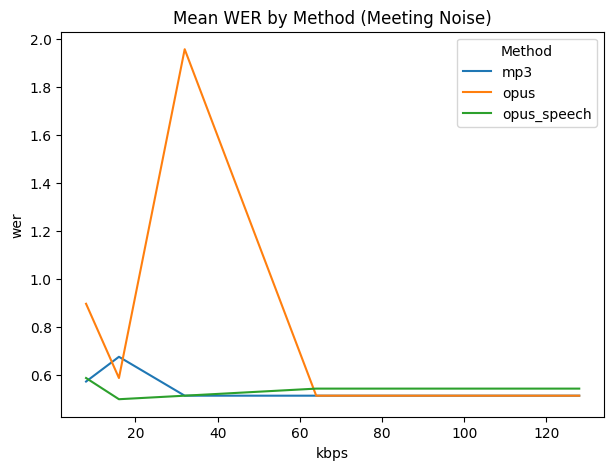

In [122]:
plt.figure(figsize=(7, 5))
sns.lineplot(data=meeting_results.groupby(["codec", "kbps"])['wer'].mean().reset_index(), 
             x='kbps', y='wer', hue='codec')
plt.title("Mean WER by Method (Meeting Noise)")
plt.legend(title='Method')
fig.set_xlabel("Bitrate (kbps)")
fig.set_ylabel("Word Error Rate")

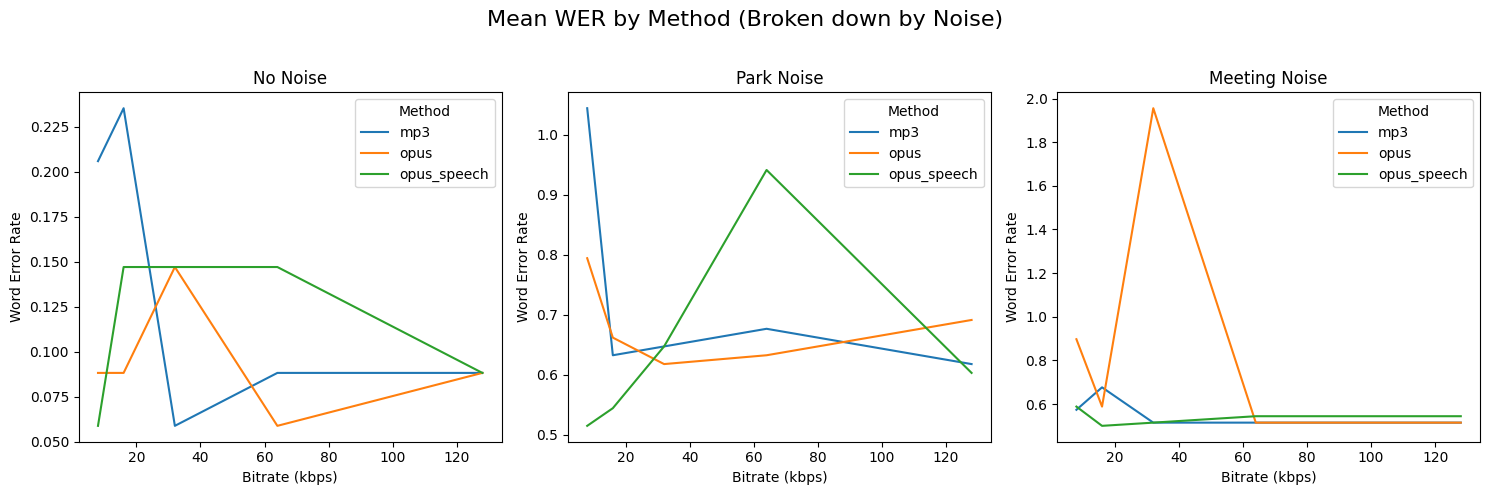

In [169]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# Define the titles for the subplots
titles = ["No Noise",
          "Park Noise",
          "Meeting Noise"]
dfs = [silence_results, park_results, meeting_results]

# Loop over the axes and create the same plot with different titles
for i, ax in enumerate(axs):
    sns.lineplot(ax=ax, data=dfs[i].groupby(["codec", "kbps"])['wer'].mean().reset_index(), 
                 x='kbps', y='wer', hue='codec')
    ax.set_title(titles[i])
    ax.set_xlabel("Bitrate (kbps)")
    ax.set_ylabel("Word Error Rate")
    ax.legend(title='Method')

# Adjust the overall title and layout
fig.suptitle("Mean WER by Method (Broken down by Noise)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect parameter to make space for the suptitle

In [168]:
park_results[park_results['snr'] == 20].groupby(["codec", "kbps"])['wer'].mean().reset_index()

,codec,kbps,wer
0,mp3,8,0.176471
1,mp3,16,0.117647
2,mp3,32,0.117647
3,mp3,64,0.117647
4,mp3,128,0.117647
5,opus,8,0.323529
6,opus,16,0.117647
7,opus,32,0.117647
8,opus,64,0.117647
9,opus,128,0.117647


In [173]:
meeting_results[meeting_results['snr'] == 20].groupby(["codec", "kbps"])['wer'].mean().reset_index()

,codec,kbps,wer
0,mp3,8,0.147059
1,mp3,16,0.147059
2,mp3,32,0.058824
3,mp3,64,0.117647
4,mp3,128,0.117647
5,opus,8,0.147059
6,opus,16,0.117647
7,opus,32,0.117647
8,opus,64,0.117647
9,opus,128,0.117647


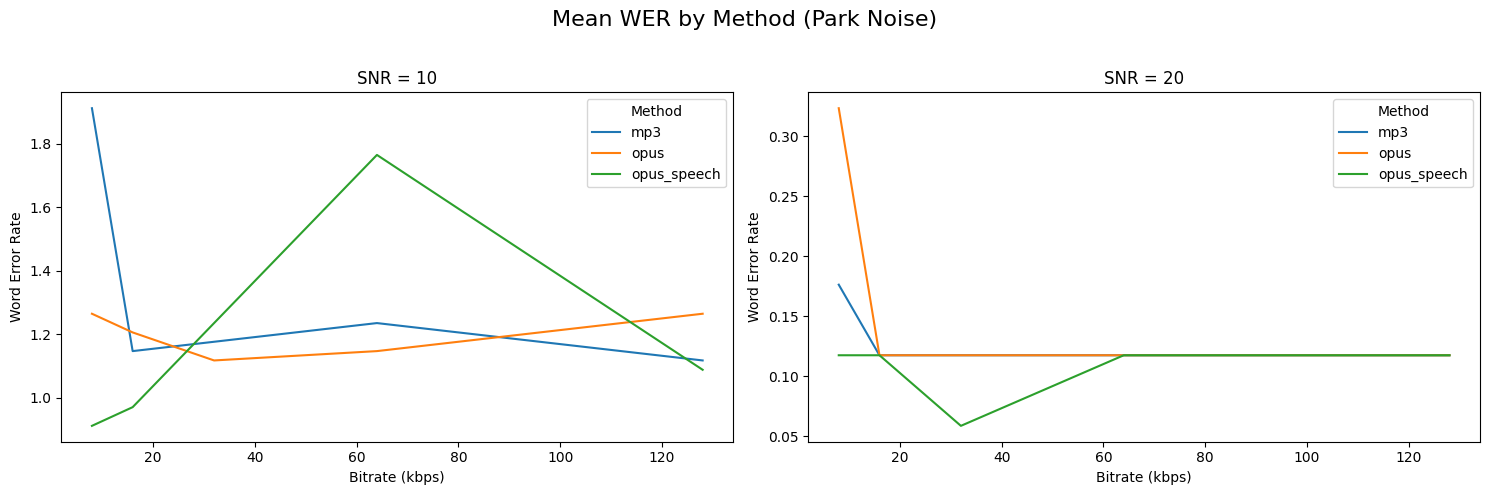

In [167]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

# Define the titles for the subplots
titles = ["SNR = 10", "SNR = 20"]
dfs = [park_results[park_results['snr'] == 10].groupby(["codec", "kbps"])['wer'].mean().reset_index(),
       park_results[park_results['snr'] == 20].groupby(["codec", "kbps"])['wer'].mean().reset_index(),]

# Loop over the axes and create the same plot with different titles
for i, ax in enumerate(axs):
    sns.lineplot(ax=ax, data=dfs[i],
                 x='kbps', y='wer', hue='codec')
    ax.set_title(titles[i])
    ax.set_xlabel("Bitrate (kbps)")
    ax.set_ylabel("Word Error Rate")
    ax.legend(title='Method')

# Adjust the overall title and layout
fig.suptitle("Mean WER by Method (Park Noise)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect parameter to make space for the suptitle

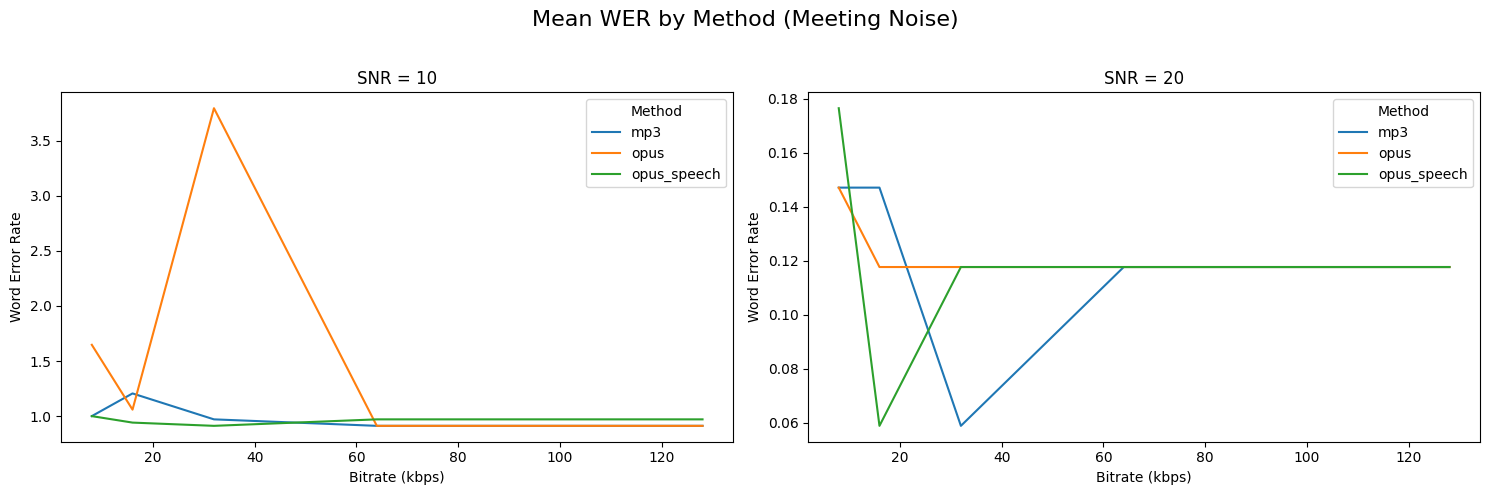

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

# Define the titles for the subplots
titles = ["SNR = 10", "SNR = 20"]
dfs = [meeting_results[meeting_results['snr'] == 10].groupby(["codec", "kbps"])['wer'].mean().reset_index(),
       meeting_results[meeting_results['snr'] == 20].groupby(["codec", "kbps"])['wer'].mean().reset_index(),]

# Loop over the axes and create the same plot with different titles
for i, ax in enumerate(axs):
    sns.lineplot(ax=ax, data=dfs[i],
                 x='kbps', y='wer', hue='codec')
    ax.set_title(titles[i])
    ax.set_xlabel("Bitrate (kbps)")
    ax.set_ylabel("Word Error Rate")
    ax.legend(title='Method')

# Adjust the overall title and layout
fig.suptitle("Mean WER by Method (Meeting Noise)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect parameter to make space for the suptitle

In [149]:
silence_results.groupby(["codec", "kbps"])['wer'].mean().reset_index()

,codec,kbps,wer
0,mp3,8,0.205882
1,mp3,16,0.235294
2,mp3,32,0.058824
3,mp3,64,0.088235
4,mp3,128,0.088235
5,opus,8,0.088235
6,opus,16,0.088235
7,opus,32,0.147059
8,opus,64,0.058824
9,opus,128,0.088235
